## Window for ShapeFit compressed parameters
In this notebook we study how to relate ShapeFit measurements of compressed parameters to the underlying model. See https://www.overleaf.com/2966435843yfhstghbvxxb.

### Template parameterization

/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


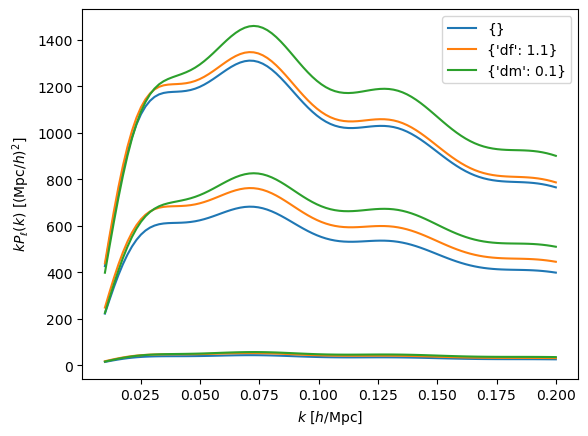

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from desilike import plotting, setup_logging
from desilike.theories.galaxy_clustering import ShapeFitPowerSpectrumExtractor, ShapeFitPowerSpectrumTemplate, DirectPowerSpectrumTemplate, BandVelocityPowerSpectrumExtractor, BandVelocityPowerSpectrumTemplate, KaiserTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable, BoxFootprint, ObservablesCovarianceMatrix
from desilike.likelihoods import ObservablesGaussianLikelihood

setup_logging()

z, b1 = 1., 2.
order = 1

def get_theory(template):
    template.init.update({'z': z, 'fiducial': 'DESI'})
    theory = KaiserTracerPowerSpectrumMultipoles(template=template)
    theory.params['b1'].update(fixed=False, value=b1)
    theory.params['sn0'].update(fixed=False, value=0.)
    return theory

theory_compression = get_theory(template=ShapeFitPowerSpectrumTemplate())

ax = plt.gca()
for iparams, params in enumerate([{}, {'df': 1.1}, {'dm': 0.1}]):
    poles = theory_compression(**params)
    for ill, ell in enumerate(theory_compression.ells):
        ax.plot(theory_compression.k, theory_compression.k * poles[ill], color='C{:d}'.format(iparams), label=str(params) if ill == 0 else None)
ax.legend()
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

### Define the likelihood for compressed parameters

In [2]:
### Define the likelihood for compressed parameters
observable_compression = TracerPowerSpectrumMultipolesObservable(klim={0: [0.01, 0.15, 0.01], 2: [0.01, 0.15, 0.01], 4: [0.01, 0.15, 0.01]},
                                                                 data={},
                                                                 theory=theory_compression)

footprint = BoxFootprint(volume=1e10, nbar=1e-3)
# Let's compute a Gaussian covariance matrix
covariance = ObservablesCovarianceMatrix(observable_compression, footprints=footprint)()
# The likelihood for our fit setup
likelihood_compression = ObservablesGaussianLikelihood(observables=observable_compression, covariance=covariance)

# Emulate the theory, to make it automatically differentiable
from desilike.emulators import Emulator, TaylorEmulatorEngine
emulator = Emulator(theory_compression, engine=TaylorEmulatorEngine(order=order))
emulator.set_samples()
emulator.fit()
# All parameters to be solved analytically
theory_compression_emulator = emulator.to_calculator()
observable_compression.init.update(theory=theory_compression_emulator)
for param in likelihood_compression.varied_params:
    param.update(prior=None, derived='.best')

/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/numpy/lib/polynomial.py:1329: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


[000003.18] [0/1] 03-15 23:15  Emulator                  INFO     Varied parameters: ['qpar', 'qper', 'dm', 'df', 'b1', 'sn0'].
[000003.18] [0/1] 03-15 23:15  Emulator                  INFO     Found varying ['f_sqrt_Ap', 'm', 'power'] and fixed ['n', 'k', 'ells'] outputs.
[000003.18] [0/1] 03-15 23:15  Differentiation           INFO     Varied parameters: ['qpar', 'qper', 'dm', 'df', 'b1', 'sn0'].
[000003.62] [0/1] 03-15 23:15  Differentiation           INFO     Using finite-differentiation for parameter qpar.
[000003.69] [0/1] 03-15 23:15  Differentiation           INFO     Using finite-differentiation for parameter qper.
[000003.73] [0/1] 03-15 23:15  Differentiation           INFO     Using finite-differentiation for parameter dm.
[000003.95] [0/1] 03-15 23:15  Differentiation           INFO     Using auto-differentiation for parameter df.
[000003.97] [0/1] 03-15 23:15  Differentiation           INFO     Using auto-differentiation for parameter b1.
[000004.00] [0/1] 03-15 23:15  Di

### Estimate window by varying the underlying model ($\Lambda$CDM) of the data

In [3]:
# Underlying model is LCDM
template_direct = DirectPowerSpectrumTemplate()
theory_direct = get_theory(template=template_direct)
for param in theory_direct.params: param.update(fixed=True)

observable_direct = observable_compression.deepcopy()
observable_direct.init.update(theory=theory_direct)

from desilike.base import BaseCalculator

# This calculator computes best fit compressed parameters, as a function of underlying model
class CompressionWindow(BaseCalculator):

    def initialize(self, likelihood, observable, quantities):
        self.likelihood = likelihood
        self.observable = observable
        self.quantities = quantities
        self.runtime_info.requires = [self.observable]

    def calculate(self):
        self.likelihood.flatdata = self.observable.flattheory.copy()
        for i in range(3):
            self.likelihood()  # find parameter best fit (iteratively in case order > 1)
        #self.likelihood.observables[0].plot(show=True)
        self.values = {}
        for quantity in self.quantities:
            self.values[quantity.name] = self.likelihood.runtime_info.pipeline.param_values[quantity.name]

    def get(self):
        return self.values

    def __getstate__(self):
        state = {'compression_{}'.format(quantity): value for quantity, value in self.values.items()}
        for name in ['quantities']: state[name] = getattr(self, name)
        return state

    def __setstate__(self, state):
        for name in ['quantities']: setattr(self, name, state[name])
        self.values = {quantity.name: state['compression_{}'.format(quantity.name)] for quantity in self.quantities}
        
compression_window = CompressionWindow(likelihood=likelihood_compression, observable=observable_direct, quantities=theory_compression.template.varied_params)
emulator = Emulator(compression_window, engine=TaylorEmulatorEngine(order=order))
emulator.set_samples()
#print(emulator.samples['compression_df']['compression_df'], emulator.samples['compression_df']['compression_df'].derivs)
emulator.fit()
emulated_compression_window = emulator.to_calculator()

[000006.22] [0/1] 03-15 23:15  Differentiation           INFO     Varied parameters: ['b1', 'sn0', 'qpar', 'qper', 'dm', 'df'].
[000008.64] [0/1] 03-15 23:15  Emulator                  INFO     Varied parameters: ['h', 'Omega_m', 'omega_b', 'logA'].
[000008.64] [0/1] 03-15 23:15  Emulator                  INFO     Found varying ['compression_qpar', 'compression_qper', 'compression_dm', 'compression_df'] and fixed ['quantities'] outputs.
[000008.64] [0/1] 03-15 23:15  Differentiation           INFO     Varied parameters: ['h', 'Omega_m', 'omega_b', 'logA'].
[000010.89] [0/1] 03-15 23:15  Differentiation           INFO     Using finite-differentiation for parameter h.
[000011.33] [0/1] 03-15 23:15  Differentiation           INFO     Using finite-differentiation for parameter Omega_m.
[000011.77] [0/1] 03-15 23:15  Differentiation           INFO     Using finite-differentiation for parameter omega_b.
[000012.22] [0/1] 03-15 23:15  Differentiation           INFO     Using finite-differenti

### Let's test our window by fitting $\Lambda$CDM models

In [4]:
observable_compression.init.update(theory=theory_compression)  # forget about emulator
observable_direct = observable_compression.deepcopy()

# For our data, use direct template (as a function of LCDM parameters)
template_direct = DirectPowerSpectrumTemplate()
theory_direct = get_theory(template=template_direct)
observable_direct.init.update(theory=theory_direct)

from desilike.profilers import MinuitProfiler

profiler = MinuitProfiler(likelihood_compression, seed=42)
bestfits, expected_no_window, expected_no_window_grid, expected_with_window = [], [], [], []


def get_expected_no_window():
    cosmo, fiducial = template_direct.cosmo, template_direct.fiducial
    shapefit_extractor(**cosmo.runtime_info.param_values)
    return {name: getattr(shapefit_extractor, name) for name in ['qpar', 'qper', 'df', 'dm']}
    # Equivalent to code below
    #rd_ratio = fiducial.rs_drag / cosmo.rs_drag 
    #qper, qpar = cosmo.comoving_angular_distance(template_direct.z) / fiducial.comoving_angular_distance(template_direct.z) * rd_ratio, fiducial.efunc(template_direct.z) / cosmo.efunc(template_direct.z) * rd_ratio
    #return {'qpar': qpar, 'qper': qper, 'dm': shapefit_extractor.dm, 'df': shapefit_extractor.df}


def get_expected_with_window():
    return emulated_compression_window(**template_direct.cosmo.runtime_info.param_values)

params = {}
#params['w0_fld'] = [-1.2, -1., -0.8]
#params['wa_fld'] = [-0.3, 0., 0.3]
params['Omega_m'] = [0.27, 0.3, 0.33]
#params['omega_b'] = [0.02, 0.02237, 0.024]
params['h'] = [0.65, 0.7, 0.75]
#params['h'] = [0.67, 0.68]
#params['Omega_m'] = [0.3, 0.32]
#params['logA'] = [2.9, 3.2]
import itertools
grid_params = [dict(zip(params.keys(), values)) for values in itertools.product(*params.values())]
for param in params:
    template_direct.params[param].update(fixed=False)

shapefit_extractor = ShapeFitPowerSpectrumExtractor(cosmo=template_direct.cosmo.copy(), fiducial=template_direct.fiducial)

theories = []
for params in grid_params:
    likelihood_compression.flatdata = observable_direct(**params).flattheory
    theories.append(observable_direct.theory)
    profiles = profiler.maximize(niterations=3)
    profiler.profiles = None
    index = profiles.bestfit.logposterior.argmax()
    bestfits.append({param.name: (profiles.bestfit[param][index], profiles.error[param][index]) for param in profiles.bestfit.params(varied=True)})
    expected_no_window.append(get_expected_no_window())
    expected_with_window.append(get_expected_with_window())
    #print('besfit', bestfits[-1])
    #print('no window', expected_no_window[-1])
    #print('with window', expected_with_window[-1])

[000019.03] [0/1] 03-15 23:15  MinuitProfiler            INFO     Varied parameters: ['qpar', 'qper', 'dm', 'df', 'b1', 'sn0'].


[000216.27] [0/1] 03-15 23:19  Plotting                  INFO     Saving figure to _tests/compression_kaiser_shapefit_lcdm.png.
[000216.31] [0/1] 03-15 23:19  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000216.32] [0/1] 03-15 23:19  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000216.51] [0/1] 03-15 23:19  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000216.52] [0/1] 03-15 23:19  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000216.73] [0/1] 03-15 23:19  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000216.73] [0/1] 03-15 23:19  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000216.87] [0/1] 03-15 23:19  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000216.87] [0/1] 03-15 23:19  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


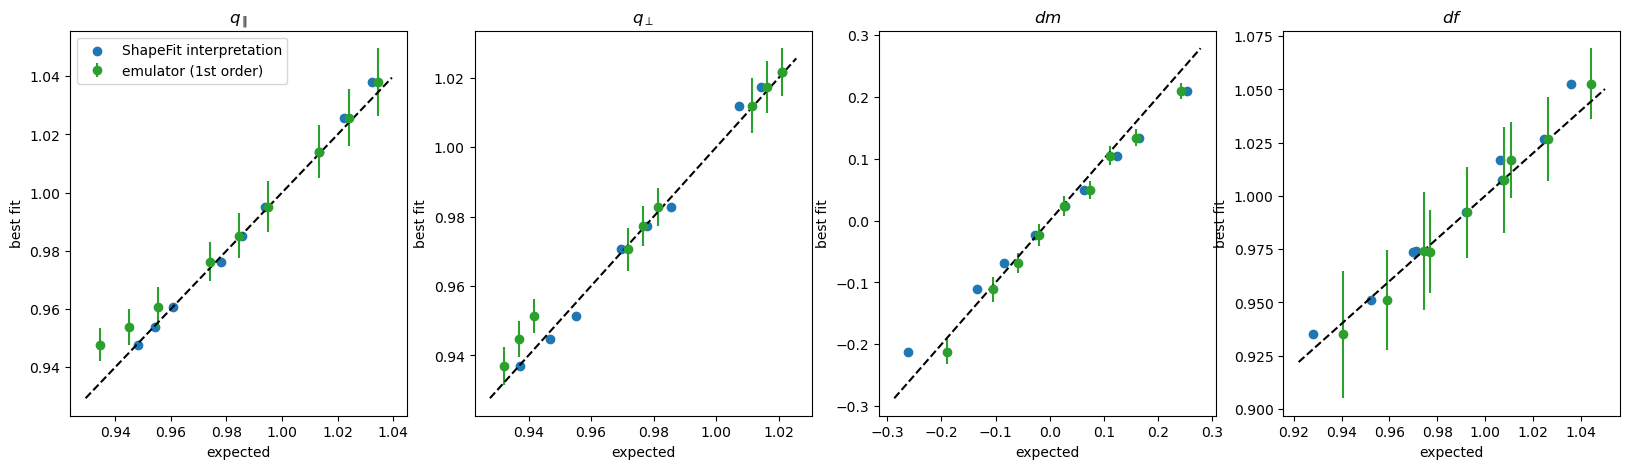

[000217.05] [0/1] 03-15 23:19  Plotting                  INFO     Saving figure to _tests/power_kaiser_shapefit_lcdm.png.


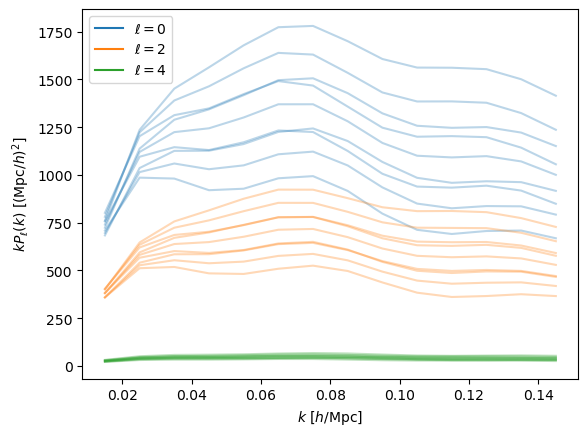

In [5]:
# Plots
params_compression = emulated_compression_window.quantities

from matplotlib import pyplot as plt
fig, lax = plt.subplots(1, len(params_compression), sharex=False, sharey=False, figsize=(len(params_compression) * 5, 5), squeeze=False)
lax = lax.flatten()
fig.subplots_adjust(hspace=0)
for iparam, param in enumerate(params_compression):
    ax = lax[iparam]
    ax.scatter([expected[param.name] for expected in expected_no_window], [bestfit[param.name][0] for bestfit in bestfits], color='C0', label='ShapeFit interpretation')
    ax.errorbar([expected[param.name] for expected in expected_with_window], [bestfit[param.name][0] for bestfit in bestfits], yerr=[bestfit[param.name][1] for bestfit in bestfits], color='C2', label='emulator (1st order)', marker='o', linestyle='')
    ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='--', color='k')
    ax.set_xlabel('expected')
    ax.set_ylabel('best fit')
    ax.set_title(param.latex(inline=True))
lax[0].legend()
plotting.savefig('_tests/compression_kaiser_shapefit_lcdm.png')
plt.show()

ax = plt.gca()
for ill, ell in enumerate(observable_direct.ells):
    for theory in theories:
        ax.plot(observable_direct.k[ill], observable_direct.k[ill] * theory[ill], color='C{:d}'.format(ill), alpha=0.3)
    ax.plot([], [], linestyle='-', color='C{:d}'.format(ill), label=r'$\ell = {:d}$'.format(ell))
ax.legend()
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plotting.savefig('_tests/power_kaiser_shapefit_lcdm.png')
plt.show()

### Estimate window by varying the underlying model ($P^{\theta\theta}$ + AP) of the data

In [6]:
observable_compression.init.update(theory=theory_compression_emulator)  # reinsert emulator

for param in likelihood_compression.varied_params:
    param.update(prior=None, derived='.best')

# Underlying model is band power + AP
kp = np.unique(np.concatenate(observable_compression.k))
theory_band = get_theory(template=BandVelocityPowerSpectrumTemplate(kp=kp))
for param in theory_band.params: param.update(fixed=True)
observable_band = observable_compression.deepcopy()
observable_band.init.update(theory=theory_band)

compression_window = CompressionWindow(likelihood=likelihood_compression, observable=observable_band, quantities=theory_compression.template.varied_params)

emulator = Emulator(compression_window, engine=TaylorEmulatorEngine(order=order))
emulator.set_samples()
emulator.fit()
emulated_compression_window = emulator.to_calculator()

[000218.21] [0/1] 03-15 23:19  Differentiation           INFO     Varied parameters: ['b1', 'sn0', 'qpar', 'qper', 'dm', 'df'].
[000218.64] [0/1] 03-15 23:19  Emulator                  INFO     Varied parameters: ['qap', 'dptt0', 'dptt1', 'dptt2', 'dptt3', 'dptt4', 'dptt5', 'dptt6', 'dptt7', 'dptt8', 'dptt9', 'dptt10', 'dptt11', 'dptt12', 'dptt13'].
[000218.64] [0/1] 03-15 23:19  Emulator                  INFO     Found varying ['pk_tt', 'compression_qpar', 'compression_qper', 'compression_dm', 'compression_df'] and fixed ['f', 'kp', 'quantities'] outputs.
[000218.65] [0/1] 03-15 23:19  Differentiation           INFO     Varied parameters: ['qap', 'dptt0', 'dptt1', 'dptt2', 'dptt3', 'dptt4', 'dptt5', 'dptt6', 'dptt7', 'dptt8', 'dptt9', 'dptt10', 'dptt11', 'dptt12', 'dptt13'].
[000219.08] [0/1] 03-15 23:19  Differentiation           INFO     Using finite-differentiation for parameter qap.
[000219.28] [0/1] 03-15 23:19  Differentiation           INFO     Using finite-differentiation for 

In [7]:
observable_compression.init.update(theory=theory_compression)
observable_direct = observable_compression.deepcopy()

# For our data, use direct template (as a function of LCDM parameters)
template_direct = DirectPowerSpectrumTemplate()
theory_direct = get_theory(template=template_direct)
observable_direct.init.update(theory=theory_direct)

from desilike.profilers import MinuitProfiler

profiler = MinuitProfiler(likelihood_compression, seed=42)
bestfits, expected_no_window, expected_with_window = [], [], []

def get_expected_with_window():
    ptt_extractor(**template_direct.cosmo.runtime_info.param_values)
    params = {'qap': ptt_extractor.qap, **{'dptt{:d}'.format(ik): ptt_extractor.dptt[ik] for ik in range(len(kp))}}
    return emulated_compression_window(**params)
    # Equivalent to code below
    #cosmo, fiducial = template_direct.cosmo, template_direct.fiducial
    #qper, qpar = cosmo.comoving_angular_distance(template_direct.z) / fiducial.comoving_angular_distance(template_direct.z), fiducial.efunc(template_direct.z) / cosmo.efunc(template_direct.z)
    #qiso = qpar**(1. / 3.) * qper**(2. / 3.)
    #qap = qpar / qper
    ## Move pk_tt to grid coordinates
    #pk_tt = 1. / qiso**3 * cosmo.get_fourier().pk_interpolator(of='theta_cb')(kp / qiso, z=template_direct.z)
    ## Compare to fiducial
    #pk_tt /= fiducial.get_fourier().pk_interpolator(of='theta_cb')(kp, z=template_direct.z)
    #params = {'qap': qap, **{'dptt{:d}'.format(ik): ptt for ik, ptt in enumerate(pk_tt)}}
    #return emulated_compression_window(**params)

params = {}
#params['w0_fld'] = [-1.2, -1., -0.8]
#params['wa_fld'] = [-0.3, 0., 0.3]
params['Omega_m'] = [0.27, 0.3, 0.33]
#params['Omega_m'] = [0.2, 0.3, 0.4]
params['h'] = [0.65, 0.7, 0.75]
grid_params = [dict(zip(params.keys(), values)) for values in itertools.product(*params.values())]
for param in params:
    template_direct.params[param].update(fixed=False)
    
ptt_extractor = BandVelocityPowerSpectrumExtractor(cosmo=template_direct.cosmo.copy(), fiducial=template_direct.fiducial, kp=kp)

theories = []
for params in grid_params:
    likelihood_compression.flatdata = observable_direct(**params).flattheory
    theories.append(observable_direct.theory)
    profiles = profiler.maximize(niterations=3)
    profiler.profiles = None
    index = profiles.bestfit.logposterior.argmax()
    bestfits.append({param.name: (profiles.bestfit[param][index], profiles.error[param][index]) for param in profiles.bestfit.params(varied=True)})
    expected_no_window.append(get_expected_no_window())
    expected_with_window.append(get_expected_with_window())

[000225.75] [0/1] 03-15 23:19  MinuitProfiler            INFO     Varied parameters: ['qpar', 'qper', 'dm', 'df', 'b1', 'sn0'].


[000466.90] [0/1] 03-15 23:23  Plotting                  INFO     Saving figure to _tests/compression_kaiser_shapefit_ptt.png.
[000466.95] [0/1] 03-15 23:23  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000466.95] [0/1] 03-15 23:23  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000467.14] [0/1] 03-15 23:23  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000467.14] [0/1] 03-15 23:23  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000467.34] [0/1] 03-15 23:23  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000467.34] [0/1] 03-15 23:23  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000467.45] [0/1] 03-15 23:23  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000467.46] [0/1] 03-15 23:23  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


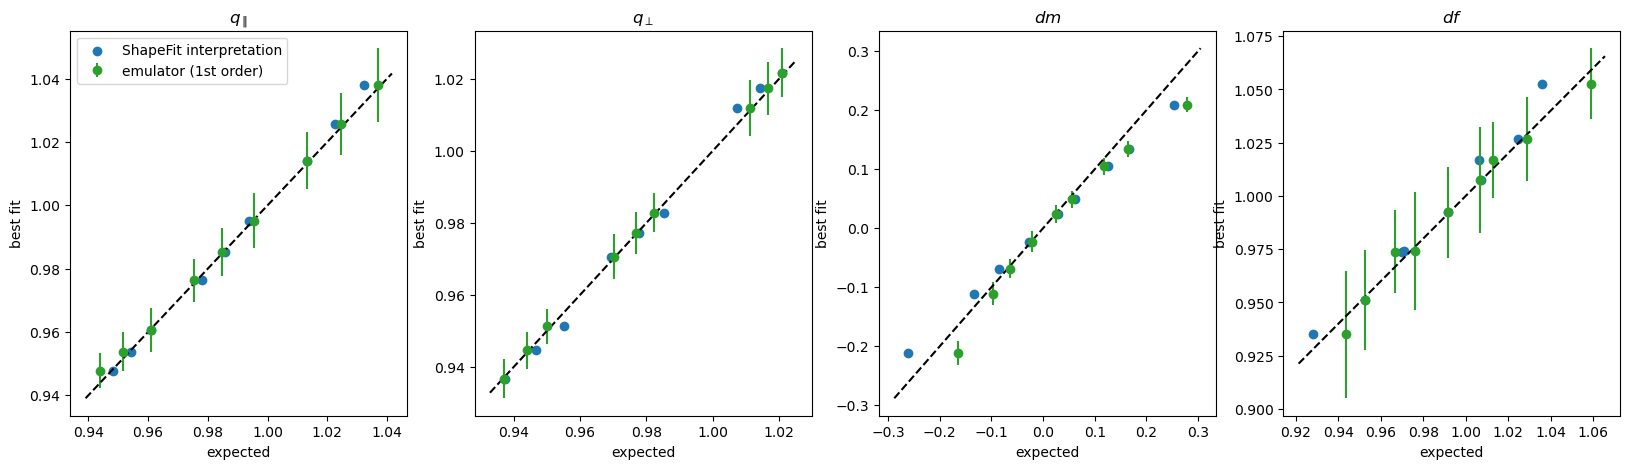

[000467.56] [0/1] 03-15 23:23  Plotting                  INFO     Saving figure to _tests/power_kaiser_shapefit_ptt.png.


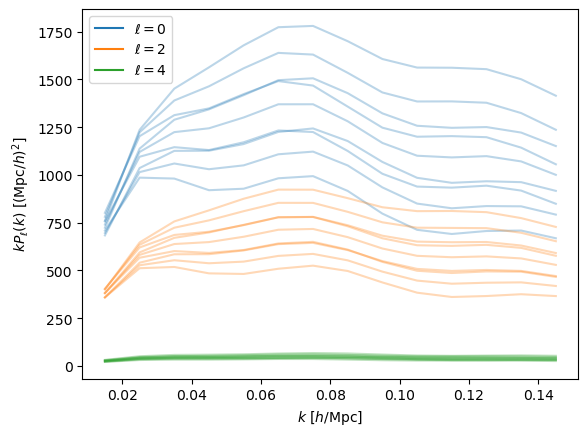

In [8]:
# Plots
params_compression = emulated_compression_window.quantities

from matplotlib import pyplot as plt
fig, lax = plt.subplots(1, len(params_compression), sharex=False, sharey=False, figsize=(len(params_compression) * 5, 5), squeeze=False)
lax = lax.flatten()
fig.subplots_adjust(hspace=0)
for iparam, param in enumerate(params_compression):
    ax = lax[iparam]
    ax.scatter([expected[param.name] for expected in expected_no_window], [bestfit[param.name][0] for bestfit in bestfits], color='C0', label='ShapeFit interpretation')
    ax.errorbar([expected[param.name] for expected in expected_with_window], [bestfit[param.name][0] for bestfit in bestfits], yerr=[bestfit[param.name][1] for bestfit in bestfits], color='C2', label='emulator (1st order)', marker='o', linestyle='')
    ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='--', color='k')
    ax.set_xlabel('expected')
    ax.set_ylabel('best fit')
    ax.set_title(param.latex(inline=True))
lax[0].legend()
plotting.savefig('_tests/compression_kaiser_shapefit_ptt.png')
plt.show()

ax = plt.gca()
for ill, ell in enumerate(observable_direct.ells):
    for theory in theories:
        ax.plot(observable_direct.k[ill], observable_direct.k[ill] * theory[ill], color='C{:d}'.format(ill), alpha=0.3)
    ax.plot([], [], linestyle='-', color='C{:d}'.format(ill), label=r'$\ell = {:d}$'.format(ell))
ax.legend()
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plotting.savefig('_tests/power_kaiser_shapefit_ptt.png')
plt.show()